# LQG Control Design and Analysis
## Investigate Robustness Issues

In [11]:
%reset -f

# Python Control Systems Library
# https://python-control.readthedocs.io/en/latest/index.html

from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    import control
except ModuleNotFoundError:
    print("Could not find control - installing")
    !pip install control

try:
    import slycot
except ModuleNotFoundError:
    print("Could not find slycot - installing")
    !pip install slycot

import control
from control.matlab import *  # MATLAB-like functions
!pwd

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
from numpy import linalg as LA
r2d = 180/np.pi

Running Python: 3.8.16
Could not find slycot - installing
/Users/jonathanhow/Documents/GitHub/16_32_Private


In [12]:
# Stick on a Cart System
A = np.array([[0, 0, 1, 0],[0,0,0,1],[31.1818, 0,0,-0.4545], [2.6727,0,0, -0.1818]])
Bu = np.array([[0],[0],[-4.5455],[-1.8182]])
Bw = Bu
Cy = np.array([[0,1,0,0]])
Cz = Cy

Rzz = 1
Rww = 1
Rvv = 0.01
Ruu = 0.01
sys_g = StateSpace(A, Bu, Cy, 0)

Nx = A.shape[0]
Ny = Cy.shape[0]
Nu = Bu.shape[1]

K, P, EP = lqr(sys_g,Cz.T*Rzz*Cz,Ruu)
L, Q, EQ = lqe(A,Bw,Cy,Rww,Rvv);
N1 = np.trace(P@(L*Rvv@L.T))
N2 = np.trace(Q@(Cz.T*Rzz@Cz))
N3 = np.trace(P@(Bw*Rww@Bw.T))
N4 = np.trace(Q@(K.T*Ruu@K))

print('Consider the 4 components of the LQG cost:')
print(np.array([[N1, N2, N3, N4]]),'\n')

# Form LQG compensator (basic form)
Ac = A - Bu@K - L@Cy
Bc = L
Cc = K 
Dc = 0
sys_comp = StateSpace(Ac,Bc,Cc,Dc)
T_loop = sys_g*sys_comp

# Form closed loop system (basic)
Acl = np.vstack((np.hstack((A,Bu@Cc)),np.hstack((-Bc@Cy,Ac))))
Bcl = np.vstack((np.zeros((Nx,Ny)), Bc ))
Ccl = np.hstack((Cy, np.zeros((Ny,Nx)) ))
Dcl = 0
Ncl = -1/(Ccl@LA.inv(Acl)@Bcl) # scaling to ensure that y step response is 1
sys_cl = StateSpace(Acl,Bcl,Ccl,Dcl)

print('Eigenvalues of the open-loop system')
P_sys=control.matlab.pole(sys_g)
Z_sys=control.matlab.zero(sys_g)
print(np.vstack(P_sys),'\n')

print('Eigenvalues of the closed loop system')
P_cl = LA.eigvals(Acl)
print(np.vstack(P_cl),'\n')
print('Should be the same as estimator and regulator poles:')
print(np.vstack(EQ))
print(np.vstack(EP),'\n')

print('Eigenvalues of the compensator')
P_comp=control.matlab.pole(sys_comp)
Z_comp=control.matlab.zero(sys_comp)
print(np.vstack(P_comp),'\n')
print('Zeros of the compensator')
print(np.vstack(Z_comp),'\n')

Consider the 4 components of the LQG cost:
[[ 4280.1729  0.1648  0.1648  4280.1729]] 

Eigenvalues of the open-loop system
[[ 0.        +0.j]
 [ 5.56510798+0.j]
 [-5.60409025+0.j]
 [-0.14281773+0.j]] 

Eigenvalues of the closed loop system
[[-5.44272159+0.30102349j]
 [-5.44272159-0.30102349j]
 [-5.44251488+0.30100765j]
 [-5.44251488-0.30100765j]
 [-2.88607854+2.58122388j]
 [-2.88607854-2.58122388j]
 [-2.88610998+2.58121639j]
 [-2.88610998-2.58121639j]] 

Should be the same as estimator and regulator poles:
[[-2.88609426+2.58122014j]
 [-2.88609426-2.58122014j]
 [-5.44261824+0.30101555j]
 [-5.44261824-0.30101555j]]
[[-5.44261824+0.30101555j]
 [-5.44261824-0.30101555j]
 [-2.88609426+2.58122014j]
 [-2.88609426-2.58122014j]] 

Eigenvalues of the compensator
[[-25.63884462+30.08450729j]
 [-25.63884462-30.08450729j]
 [ 23.09439393 +0.j        ]
 [ -4.94975469 +0.j        ]] 

Zeros of the compensator
[[-3.37186187e+17+0.j]
 [-5.60409057e+00+0.j]
 [-2.46965903e-01+0.j]
 [ 1.48503681e-01+0.j]] 

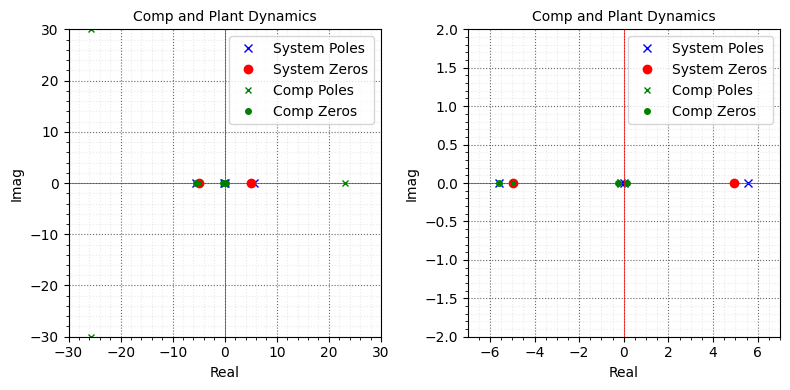

In [4]:
plt.figure(figsize=(8,4))
ax2 = plt.subplot(121)
ax2.plot(P_sys.real,P_sys.imag,'bx',ms=6,label='System Poles')
ax2.plot(Z_sys.real,Z_sys.imag,'ro',ms=6,label='System Zeros')
ax2.plot(P_comp.real,P_comp.imag,'gx',ms=4,label='Comp Poles')
ax2.plot(Z_comp.real,Z_comp.imag,'go',ms=4,label='Comp Zeros')
ax2.plot([0,0],[-30,30],'r-',lw=0.5)
ax2.plot([-30,30],[0,0],'r-',lw=0.5)
ax2.set_xlim([-30,30])
ax2.set_ylim([-30,30])
plt.xlabel('Real')
plt.ylabel('Imag')
nicegrid()
plt.title('Comp and Plant Dynamics')
plt.legend()
ax2 = plt.subplot(122)
ax2.plot(P_sys.real,P_sys.imag,'bx',ms=6,label='System Poles')
ax2.plot(Z_sys.real,Z_sys.imag,'ro',ms=6,label='System Zeros')
ax2.plot(P_comp.real,P_comp.imag,'gx',ms=4,label='Comp Poles')
ax2.plot(Z_comp.real,Z_comp.imag,'go',ms=4,label='Comp Zeros')
ax2.plot([0,0],[-30,30],'r-',lw=0.5)
ax2.plot([-30,30],[0,0],'r-',lw=0.5)
ax2.set_xlim([-7,7])
ax2.set_ylim([-2,2])
nicegrid()
plt.title('Comp and Plant Dynamics')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.legend()
plt.tight_layout()
plt.show()

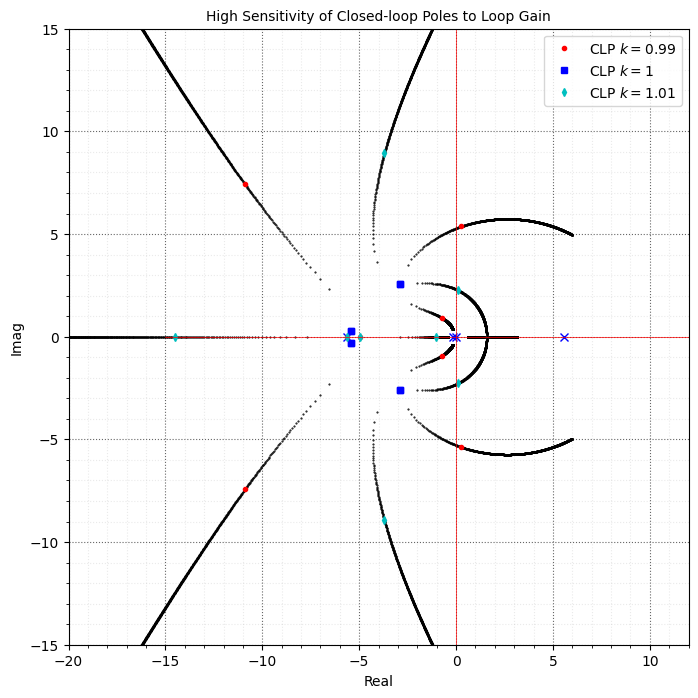

In [10]:
plt.figure(figsize=(8,8))
ax2 = plt.subplot(111)
ax2.plot(P_sys.real,P_sys.imag,'bx',ms=6)
rlist = control.root_locus(T_loop,kvect=np.linspace(0.85,1.2,num=2500),plot=False)
rlist1 = control.root_locus(T_loop,kvect=np.array([0.99,1,1.01]),plot=False)
ax2.plot(rlist[0].real,rlist[0].imag,'k.',ms=1)
ax2.plot(rlist1[0][0].real,rlist1[0][0].imag,'r.',ms=6,label=r'CLP $k=0.99$')
ax2.plot(rlist1[0][1].real,rlist1[0][1].imag,'bs',ms=4,label=r'CLP $k=1$')
ax2.plot(rlist1[0][2].real,rlist1[0][2].imag,'cd',ms=4,label='CLP $k=1.01$')
ax2.plot([0,0],[-15,15],'r-',lw=0.5)
ax2.plot([-15,15],[0,0],'r-',lw=0.5)
ax2.set_xlim([-20,12])
ax2.set_ylim([-15,15])
nicegrid()
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('High Sensitivity of Closed-loop Poles to Loop Gain')
plt.legend()
plt.show()

Crossover freq =  [ 2.3020  2.3177  5.2411  5.2768  5.3128  17.3436]  rad/sec
Gain at crossover =  [ 0.9914  0.9914  1.0081  1.0082  1.0083  0.8754]
Approx S at crossover =  [ 115.7704  116.8112  122.8908  121.6633  120.5151  8.0234]


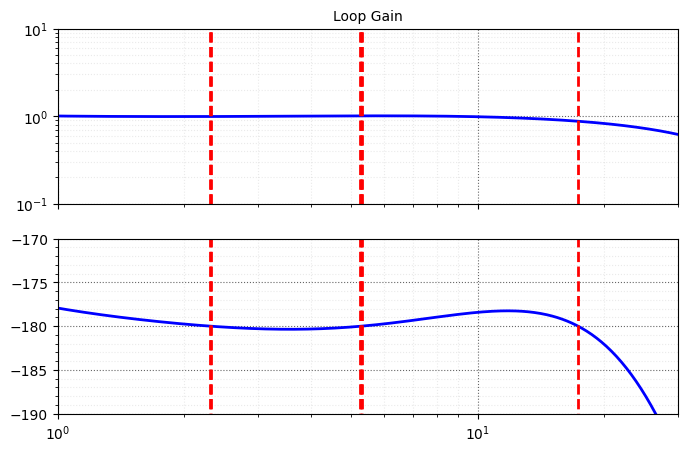

In [6]:
w = np.logspace(-1.2,1.75,1000)
mag,phase,omega = control.bode(T_loop,w,Hz=False,dB=False,deg=True,plot=False)

# find the cross-over frequency and gain at cross-over
index = np.abs(phase - (-np.pi)) < 2.5e-4
wc= w[index]

print('Crossover freq = ', wc, ' rad/sec')
print('Gain at crossover = ', mag[index])
print('Approx S at crossover = ', np.abs(1/(1-mag[index])))

fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(8,5))
ax1.loglog(w,mag)
nicegrid(ax1)
ax1.set_xlim([1,30])
ax1.set_ylim([.1,10])

for jj in wc:
    ax1.plot([jj,jj],ax1.set_ylim(),'r--')
ax1.set_title("Loop Gain")

ax2.semilogx(w,phase*r2d)
for jj in wc:
    ax2.plot([jj,jj],plt.ylim(),'r--')
ax2.set_ylim([-190,-170])
ax2.set_xlim([1,30])
nicegrid(ax2)
plt.show()

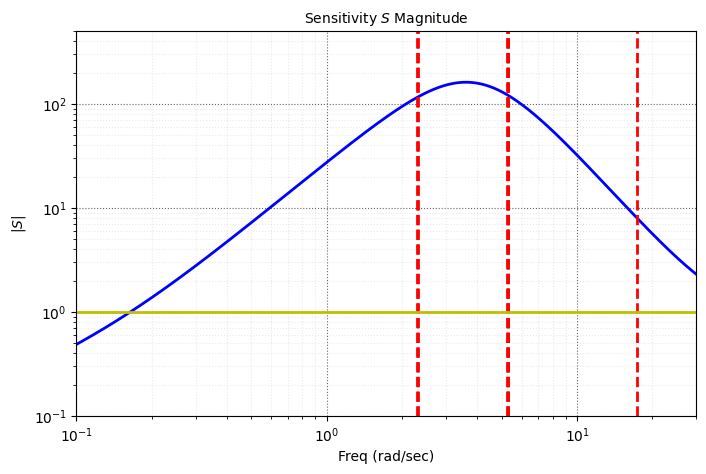

In [7]:
S = control.feedback(ss(0,0,0,1),T_loop)
mag,phase,omega = control.bode(S,w,Hz=False,dB=False,deg=True,plot=False)

fig, (ax1) = plt.subplots(1, sharex=True, figsize=(8,5))
plt.loglog(w,mag)
nicegrid()
plt.xlim([.1,30])
plt.ylim([.1,500])
for jj in wc:
    plt.plot([jj,jj],[.01,500],'r--')
plt.plot(plt.xlim(),[1,1],'y-')
plt.xlabel('Freq (rad/sec)')
plt.ylabel('$|S|$')
plt.title("Sensitivity $S$ Magnitude")
plt.show()

Sensitivity values of 100 indicate that the system is very fragile!

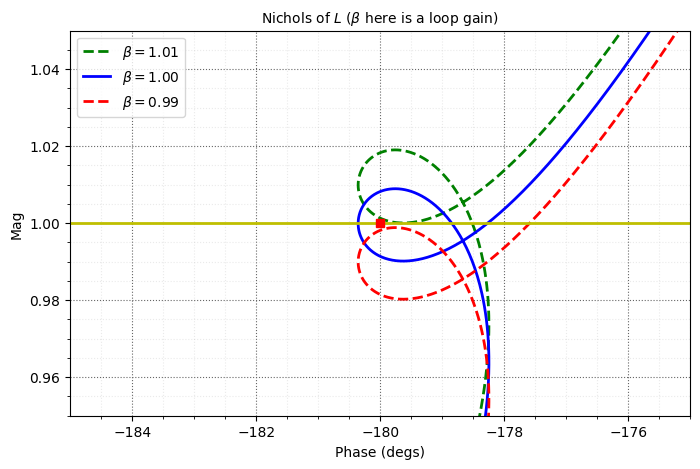

In [8]:
L_mag,L_phase,omega = control.bode(T_loop,w,Hz=False,dB=False,deg=True,plot=False)

fig, (ax1) = plt.subplots(1, sharex=True, figsize=(8,5))
plt.plot(L_phase*r2d,1.01*L_mag,'g--',label=r'$\beta=1.01$')
plt.plot(L_phase*r2d,L_mag,label=r'$\beta=1.00$')
plt.plot(L_phase*r2d,0.99*L_mag,'r--',label=r'$\beta=0.99$')
nicegrid()
plt.xlim([-185,-175])
plt.ylim([.95,1.05])
plt.plot(plt.xlim(),[1,1],'y-')
plt.plot(-180,1,'rs')
plt.xlabel('Phase (degs)')
plt.ylabel('Mag')
plt.title(r"Nichols of $L$ ($\beta$ here is a loop gain)")
plt.legend()
plt.show()

Nominal solution has right number of encirclements of the critical point (closed loop stable) -- changing the loop gains lightly changes the number of encirclements, indicative of closed-loop unstable!